In [1]:
from src.pipelines.pipeline_pose2img import Pose2ImagePipeline
from src.models.pose_guider import PoseGuider
from src.models.unet_2d_condition import UNet2DConditionModel
from src.models.unet_3d import UNet3DConditionModel
from src.pipelines.pipeline_pose2img import Pose2ImagePipeline
from diffusers import AutoencoderKL, DDIMScheduler
from transformers import CLIPVisionModelWithProjection
import torch
from omegaconf import OmegaConf
from src.dwpose import DWposeDetector, draw_pose
from controlnet_aux.util import HWC3, resize_image
from PIL import Image
import matplotlib.pyplot as plt
from tools.openpose_rescaler import draw, rescale_skeleton, crop_and_resize
import numpy as np
import cv2
from src.utils.util import get_fps, read_frames

/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being regist

In [2]:
weight_dtype = torch.float32
device = 'cuda:7'

vae_model_path = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/sd-vae-ft-mse'

base_model_path = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/sd-image-variations-diffusers'

image_encoder_path = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/sd-image-variations-diffusers/image_encoder'

config = OmegaConf.load('/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/configs/train/stage1.yaml')

sched_kwargs = OmegaConf.to_container(config.noise_scheduler_kwargs)
if config.enable_zero_snr:
    sched_kwargs.update(
        rescale_betas_zero_snr=True,
        timestep_spacing="trailing",
        prediction_type="v_prediction",
    )
    
val_noise_scheduler = DDIMScheduler(**sched_kwargs)

vae = AutoencoderKL.from_pretrained(vae_model_path).to(
        device, dtype=weight_dtype
    )

reference_unet = UNet2DConditionModel.from_pretrained(
    base_model_path,
    subfolder="unet",
).to(device=device)

denoising_unet = UNet3DConditionModel.from_pretrained_2d(
    base_model_path,
    "",
    subfolder="unet",
    unet_additional_kwargs={
        "use_motion_module": False,
        "unet_use_temporal_attention": False,
    },
).to(device=device)

image_enc = CLIPVisionModelWithProjection.from_pretrained(
    image_encoder_path,
).to(dtype=weight_dtype, device=device)

pose_guider = PoseGuider(
            conditioning_embedding_channels=320, block_out_channels=(16, 32, 96, 256)
        ).to(device=device)


detector = DWposeDetector()
detector = detector.to(device)

Some weights of the model checkpoint were not used when initializing UNet2DConditionModel: 
 ['conv_norm_out.weight, conv_norm_out.bias, conv_out.weight, conv_out.bias']
/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2024-02-22 18:23:18.784090403 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-02-22 18:23:18.784111943 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with

In [3]:
ref_net_weight_path = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/stage1_out/stage1_512_fintune_refnet_posguider_hdtf_tiktok/reference_unet-20000.pth'

unet_weight_path = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/opensource_stage1/denoising_unet-0.pth'

pose_guider_weight_path = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/stage1_out/stage1_512_fintune_refnet_posguider_hdtf_tiktok/pose_guider-20000.pth'

In [4]:
denoising_unet.load_state_dict(torch.load(unet_weight_path, map_location="cpu",),strict=False)

reference_unet.load_state_dict(torch.load(ref_net_weight_path, map_location="cpu"),strict=False)

pose_guider.load_state_dict(torch.load(pose_guider_weight_path,map_location="cpu"),strict=False)


pipe = Pose2ImagePipeline(
        vae=vae,
        image_encoder=image_enc,
        reference_unet=reference_unet,
        denoising_unet=denoising_unet,
        pose_guider=pose_guider,
        scheduler=val_noise_scheduler,
    ).to(device)

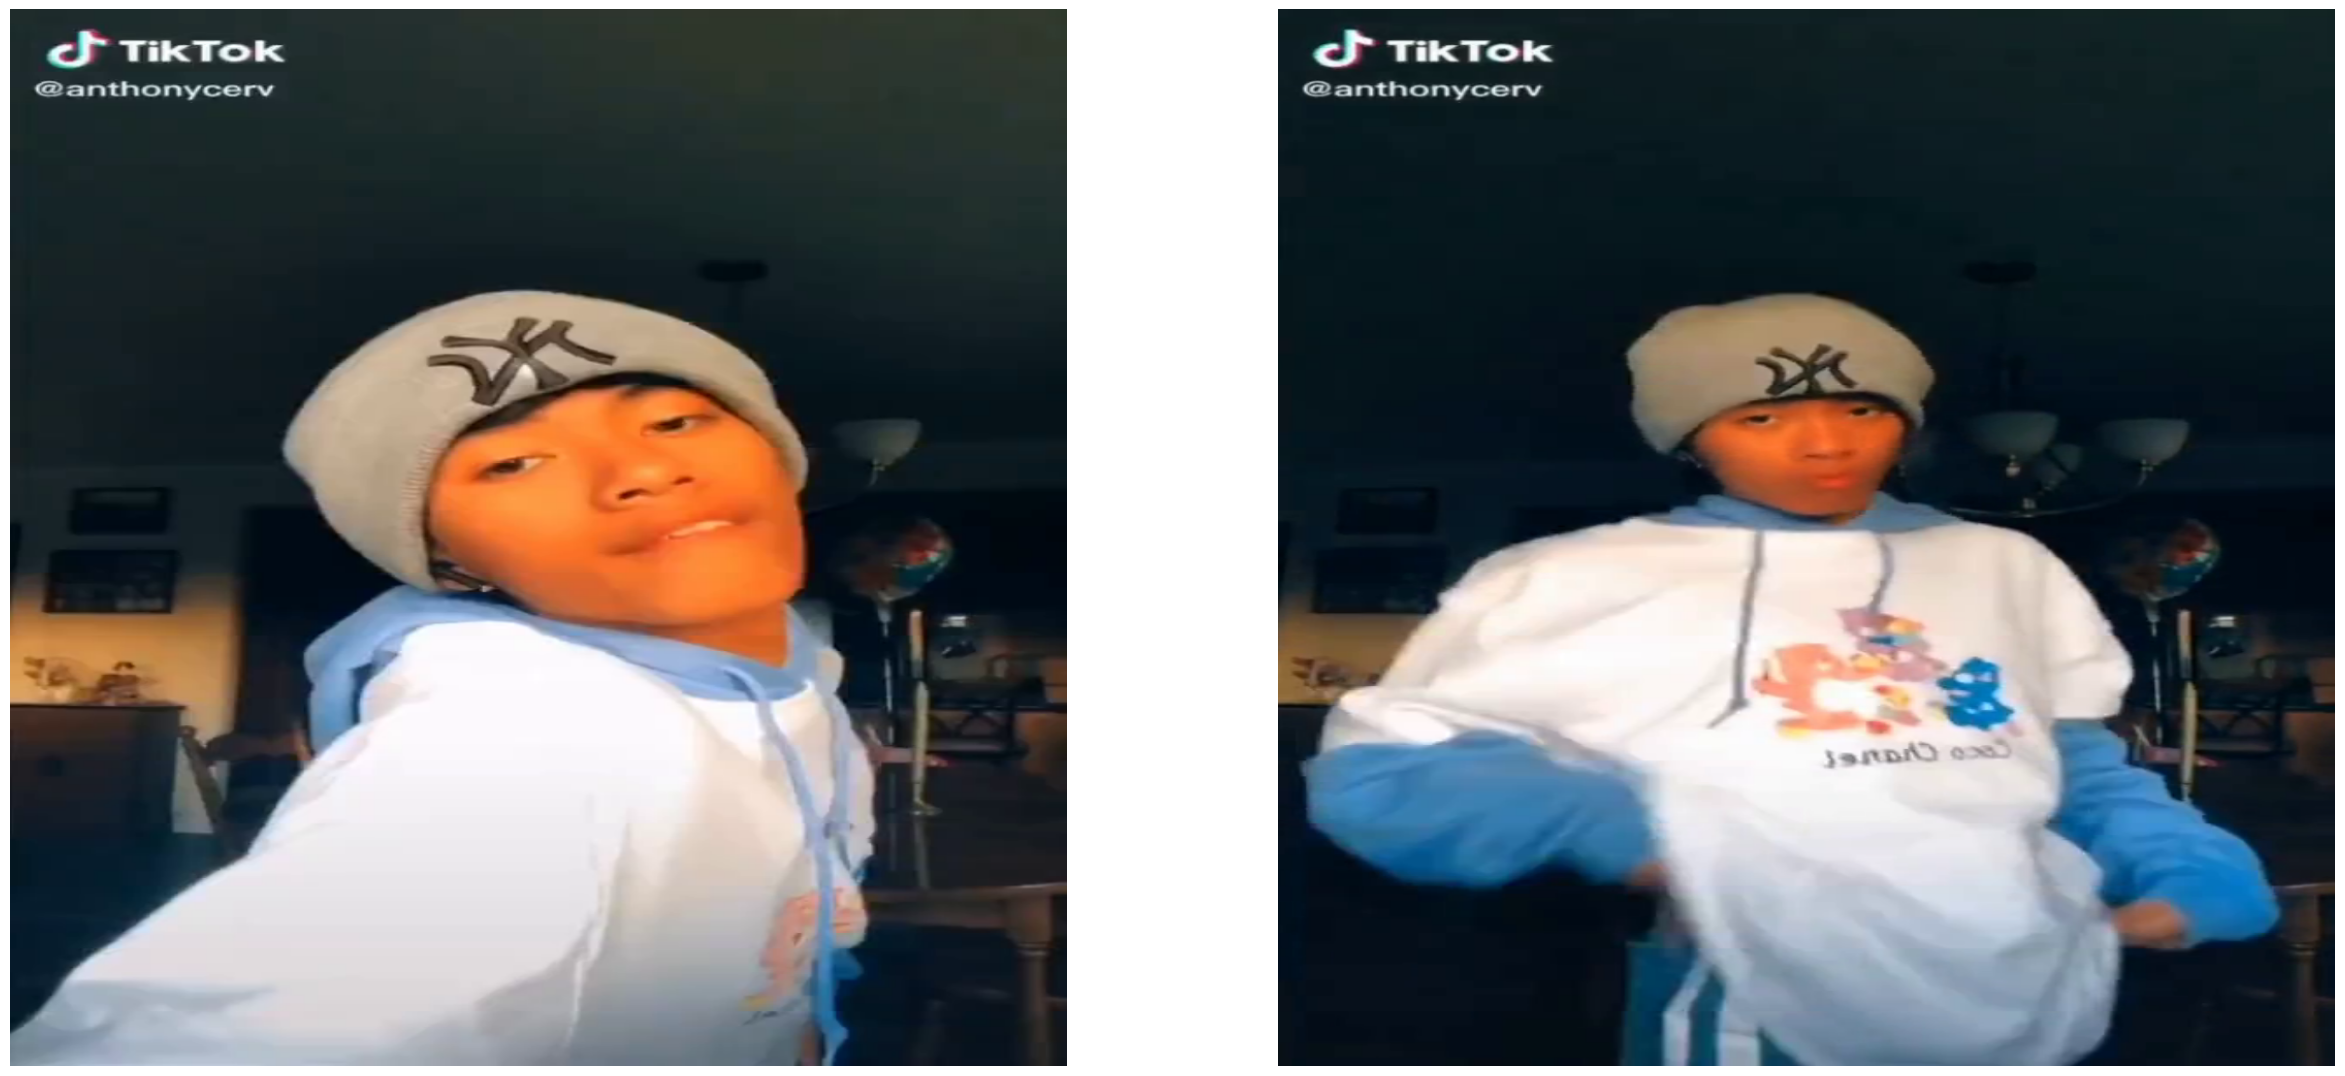

In [30]:
ref_image_file = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/assets/ref_image/anime_sample.jpeg'

pose_image_file = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/configs/inference/ref_images/sample_00038_.png'

pose_image_vid = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/assets/video_clips/vid_kiss.mp4'

frame = 50

W = 1024
H = 1024

ref_image = cv2.resize(np.array(Image.open(ref_image_file)), (W,H))

first_frame = cv2.resize(np.array(read_frames(pose_image_vid)[0]), (W,H))

ref_image = first_frame

pose_image= Image.open(pose_image_file)

pose_image_from_vid = read_frames(pose_image_vid)[frame]

use_vid = 1

ref_image = Image.fromarray(ref_image)

if use_vid:
    pose_image = pose_image_from_vid
    
pose_image = Image.fromarray(cv2.resize(np.array(pose_image), (W,H)))

fig, axs = plt.subplots(1, 2, figsize=(30, 16))
img_list = [ref_image, pose_image]

for i, img in enumerate(img_list):
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

In [31]:
torch.cuda.empty_cache()
print('extracting skeleton...')
skeleton, score, ref_pose_keypoints = detector(pose_image, output_type='key_points', face=True)
print('extraction done')
# skeleton = Image.open('/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/configs/inference/ref_images/openpose_2people.png')
res_img = pipe(ref_image, skeleton, W, H, 25, 3.5).images
res_img = res_img[0, :, 0].permute(1, 2, 0).cpu().numpy()  # (3, 512, 512)
res_image_pil = Image.fromarray((res_img * 255).astype(np.uint8))

extracting skeleton...
extraction done


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 146.08it/s]


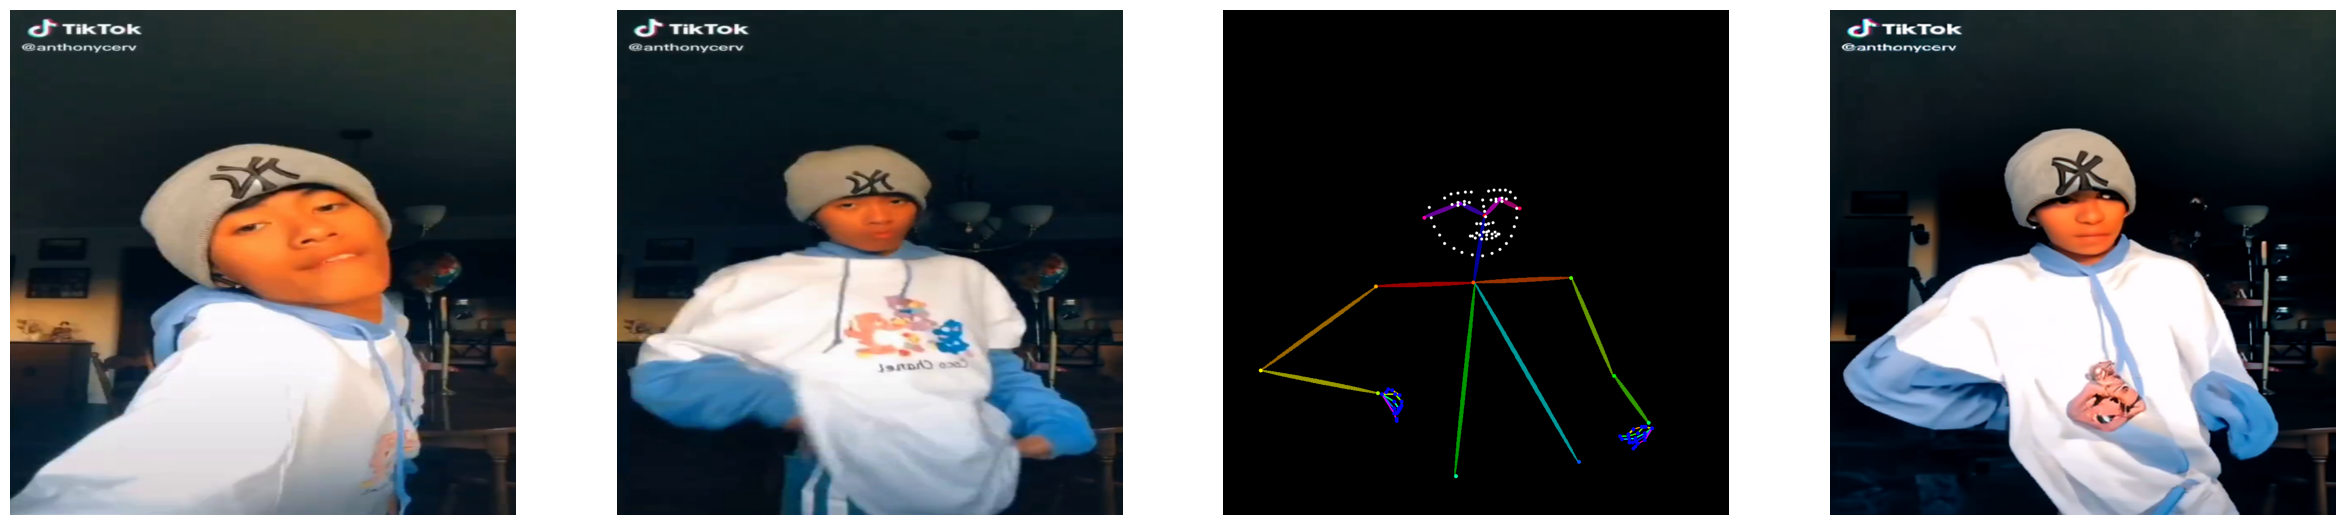

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(30, 16))
img_list = [ref_image, pose_image, skeleton, res_image_pil]

for i, img in enumerate(img_list):
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()